# Diffusion Generative Modelling for Simulation-Based Inference

An introduction to diffusion generative models in SBI to learn and sample from posterior distributions in the setiing of tall context data. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(1)

import sys
sys.path.append("../")

N_TRAIN = 10_000
N_SAMPLES = 4096

## SBI Task: Simulator, Prior and True/Target Posterior 

- Prior (2D): $\lambda(\theta) = \mathcal{N}(\mu_\lambda, \Sigma_\lambda)$ with $\mu_\lambda = (0, 175)$ and $\Sigma_\lambda = \begin{pmatrix} 5^2 & 1 \\ 1 & 25^2 \end{pmatrix}$
- Simualtor (2D): $x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) = \mathcal{N}(\theta, \Sigma)$ with $\Sigma = \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}$

Goal: estimate $p(\theta\mid x_0)$ with $x_0$ an observation.

N.B.: the true posterior is the productoct of two Gaussians, i.e. a Gaussian $\mathcal{N}(\mu_\text{post}, \Sigma_\text{post})$ with $\mu_\text{post} = \Sigma_\text{post} \left(\Sigma^{-1}_\lambda\mu_\lambda + \Sigma^{-1}x_0\right)$ and $\Sigma_\text{post} = (\Sigma^{-1}_\lambda + \Sigma^{-1})^{-1}$.

In [2]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior
from tasks.toy_examples.data_generators import SBIGaussian2d

# Task
task = SBIGaussian2d(prior_type="gaussian")
# Prior and Simulator
prior = task.prior
simulator = task.simulator

# Observation
theta_true = torch.FloatTensor([-5, 150])  # true parameters
x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
observation = {"theta_true": theta_true, "x_obs": x_obs}

# True posterior: P(theta|x_0)
true_posterior = task.true_posterior(x_obs)

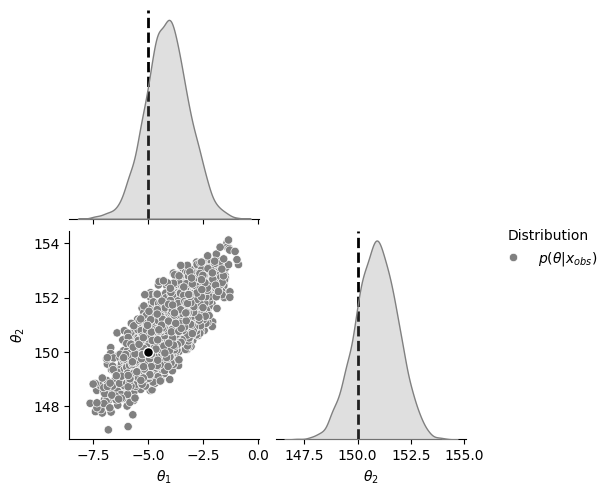

In [3]:
# Plot True posterior: P(theta | x_obs)

from plot_utils import pairplot_with_groundtruth_2d

samples_true = true_posterior.sample((N_SAMPLES,)).numpy()

pg = pairplot_with_groundtruth_2d(
    samples_list=[samples_true],
    labels=[r"$p(\theta | x_{obs})$"],
    colors=["grey"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
)


The simulator is stochastic, meaning that a generated observation `x_obs` might not correspond to the most probable one. In this case, the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ is centered around $x_0$=`x_obs` and not $\theta_0$=`theta_true`.

Indeed: $p(\theta \mid x_0) = p(x_0\mid \theta)p(\theta)/p(x_0) = p(x_0\mid \theta)$ because $p(\theta) \sim \mathcal{U}(0,1)$ is uniform. Finally we have that $p(\theta \mid x_0) = p(x_0\mid \theta) =p_{\mathcal{N}(\theta, \Sigma)}(x_0) = p_{\mathcal{N}(x_0, \Sigma)}(\theta) = \mathcal{N}(x_0, \Sigma)$ because of the symmetry of the gaussian distribution.

In order to solve this stochasticity problem and get a posterior centered around the true parameters `theta_true` (i.e. that generated `x_obs`), we would need more than one observation simulated using the true parameter $\theta_0$ to get an empirical approximation of the mean of the simulator likelihood:
$$x_i \sim p(x\mid \theta_0) = \mathcal{N}(\theta_0,\Sigma) \rightarrow x_{mean} = \frac{1}{n}\sum x_i \approx \theta_0$$

So $p(\theta \mid x_{mean}) \approx p(\theta \mid \theta_0) =\mathcal{N}(\theta_0, \Sigma)$.



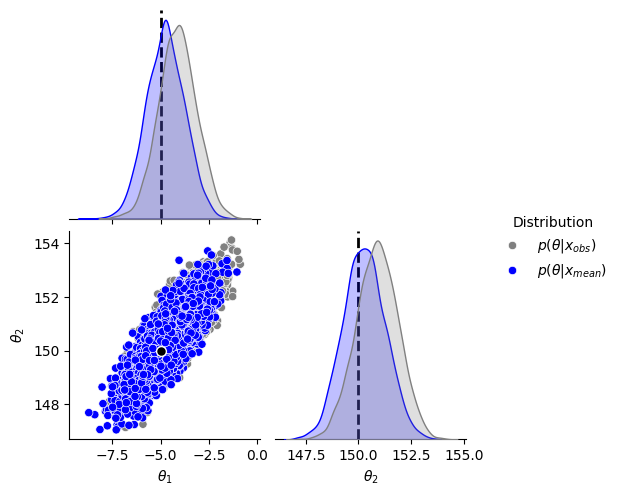

In [4]:
# Plot p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)

x_obs_100 = torch.cat([simulator(theta_true).reshape(1, -1) for i in range(100)], dim=0)
true_posterior_100 = task.true_posterior(torch.mean(x_obs_100, axis=0))
samples_true_100 = true_posterior_100.sample((N_SAMPLES,)).numpy()

pairplot_with_groundtruth_2d(
    samples_list=[samples_true, samples_true_100],
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"],
    colors=["grey", "blue"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
)


## Posterior Estimation via Score-Matching
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$ using score-matching.

See [[Sharrock et al. (2022)]](https://arxiv.org/abs/2210.04872).

### Data Generation

In [5]:
# Train data
theta_train = task.prior.sample((N_TRAIN,))
x_train = simulator(theta_train)

# normalize theta
theta_train_ = (theta_train - theta_train.mean(axis=0)) / theta_train.std(axis=0)

# normalize x
x_train_ = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_ = (x_obs - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_100_ = (x_obs_100 - x_train.mean(axis=0)) / x_train.std(axis=0)


### Neural Posterior Score Estimation (NPSE)

Training the score model consists in minimizing the DSM loss, i.e. the expectation over the uniformly distributed time frame in $[0,T]$ of the weighted DSM losses. 
$$\mathcal{L}^{\mathrm{DSM}}(\phi) = \mathbb{E}_{\mathcal{U}(0,T)} \Big[\lambda_t \mathcal{L}^{\mathrm{DSM}_t}(p_t, \phi)\Big]$$

We are in a conditional case, the DSM losses depend on data from the joint distribution $p(\theta,x)$ and the score model $s_\phi(\theta,x,t)$ depends on the context varaible $x$, in addition to the target varaible $\theta$ and the time variable $t$: 

$$ \mathcal{L}^{\mathrm{DSM}_t}(p_t,\phi) = \mathbb{E}_{p_{t\mid0}(\theta(t)|\theta(0)), p(\theta(0),x)}\left[||s_{\phi}(\theta(t),x, t)-\nabla_\theta \log p_{t\mid0}(\theta(t)\mid \theta(0))||^2\right]$$

> Note that only the target variable $\theta$ is diffused via the SDE forward transition kernel $p_{t0}(\theta(t)\mid \theta(0))$ and $\theta(0) \sim p(\theta), x \sim p(x\mid \theta(0))$ are data from the joint.

#### Define and train Score Model

In [6]:
# score_network
from nse import NSE, NSELoss
from sm_utils import train

# torch.set_default_device("cuda:0")
dataset = torch.utils.data.TensorDataset(theta_train_.cuda(), x_train_.cuda())
score_net = NSE(theta_dim=2, x_dim=2, hidden_features=[128, 256, 128]).cuda()



In [7]:
avg_score_net = train(
    model=score_net,
    dataset=dataset,
    loss_fn=NSELoss(score_net),
    n_epochs=200,
    lr=1e-3,
    batch_size=256,
    prior_score=False, # learn the prior score via the classifier-free guidance approach
)
score_net = avg_score_net.module

Training epochs: 100%|██████████| 200/200 [00:47<00:00,  4.25it/s, loss=0.0418]


#### Sample from the approximate posterior

In [8]:
# sample from the appeoximate posterior
samples_npse = score_net.ddim((N_SAMPLES,), x=x_obs_.cuda(), steps=256).detach().cpu()
# # unnormalize samples
samples_npse = samples_npse * theta_train.std(axis=0) + theta_train.mean(axis=0)

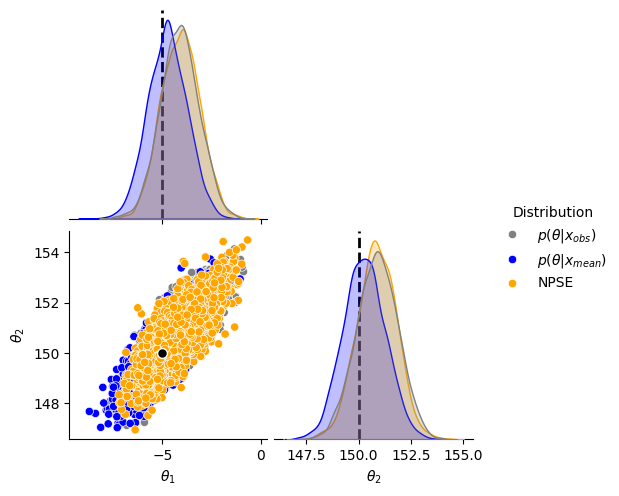

In [9]:
# Plot True vs. learned posteriors: P(theta | x_obs)
samples_list=[samples_true, samples_true_100, samples_npse]

pairplot_with_groundtruth_2d(
    samples_list=samples_list,
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$", "NPSE"],
    colors=["grey", "blue", "orange"],
    theta_true=theta_true
)


## Aggregated score by Tweedie's

### Replacing our approximation in the Langevin scheme

Below, we test replacing the F-NPSE score with our new version that incorporates the correction term L.


In [10]:
from vp_diffused_priors import get_vpdiff_gaussian_score

loc_ = prior.prior.loc - theta_train.mean(axis=0)
cov_ = prior.prior.covariance_matrix / theta_train.std(axis=0) ** 2

diffused_prior_score = get_vpdiff_gaussian_score(loc_.cuda(), cov_.cuda(), nse=score_net)

# try with learned prior score
# diffused_prior_score = lambda theta,t: score_net.score(theta=theta, x=torch.zeros_like(x_obs_100[:10]).cuda(), t=t)

#### Analyzing the correction term `L`

**ATTENTION**: Scaling Issue - Higher amounts of added correction term `L` still give erronated results (see below). 

In [18]:
# n=10
samples_per_correction = {}
for correction_lda in [0, 1e-2, 1e-1, 3e-1, 5e-1]: # amount of correction term L in addition to the original F-NPSE
    samples_langevin_ = score_net.predictor_corrector((N_SAMPLES,),
                                                      x=x_obs_100_[:10].cuda(),
                                                      steps=400,
                                                      prior_score_fun=diffused_prior_score,
                                                      eta=0.01,
                                                      corrector_lda=correction_lda,
                                                      n_steps=5,
                                                      r=.5,
                                                      predictor_type='ddim',
                                                      verbose=True).cpu()
    samples_per_correction[correction_lda] = samples_langevin_ * theta_train.std(axis=0) + theta_train.mean(axis=0)

 86%|████████▋ | 346/400 [01:42<00:14,  3.67it/s]

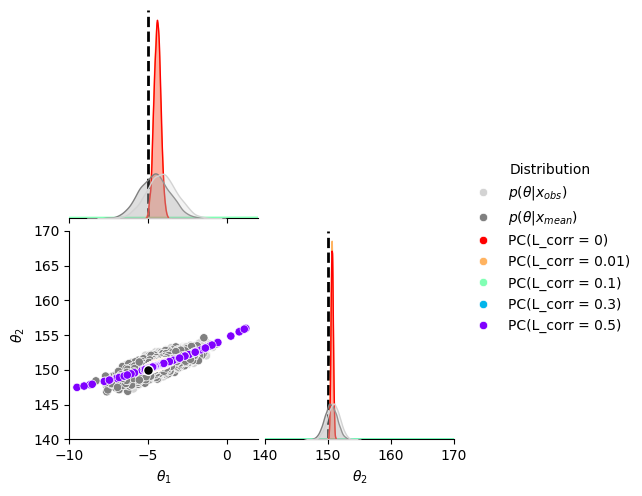

In [ ]:
from matplotlib import colormaps as cm
samples_true_mean = task.true_posterior(torch.mean(x_obs_100[:10], axis=0)).sample((N_SAMPLES,)).numpy()
pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_correction.values()),
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC(L_corr = {k})" for k in samples_per_correction],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_correction)).cpu()],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [140, 170]),
)

#### Scaling to large number `n` of observations

In [15]:
# ddim 
samples_per_n = {}
for n_observations in [10,20,30,50]: # amount of correction term L in addition to the original F-NPSE
    samples_langevin_ = score_net.predictor_corrector((N_SAMPLES,),
                                                      x=x_obs_100_[:n_observations].cuda(),
                                                      steps=1000,
                                                      prior_score_fun=diffused_prior_score,
                                                      eta=1,
                                                      corrector_lda=0,
                                                      n_steps=0,
                                                      r=.5,
                                                      predictor_type='ddim',
                                                      verbose=True).cpu()
    samples_per_n[n_observations] = samples_langevin_ * theta_train.std(axis=0) + theta_train.mean(axis=0)

100%|██████████| 1000/1000 [03:09<00:00,  5.27it/s]


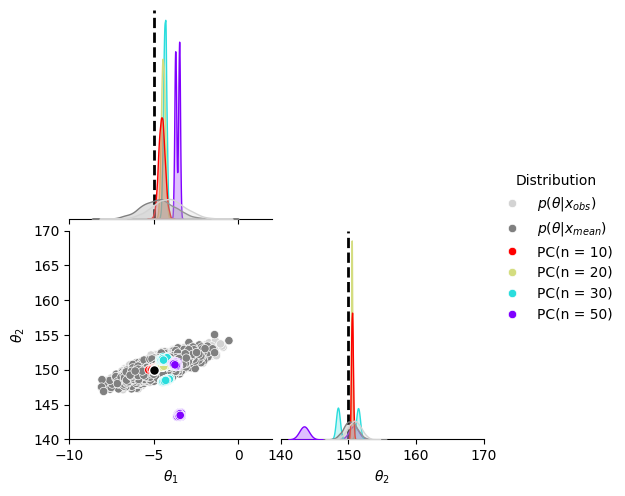

In [16]:
from matplotlib import colormaps as cm
samples_true_mean = task.true_posterior(torch.mean(x_obs_100[:100], axis=0)).sample((N_SAMPLES,)).numpy()
pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_n.values()),
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC(n = {k})" for k in samples_per_n],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_n)).cpu()],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [140, 170]),
)

In [11]:
# id (original PF-NPSE) 
samples_per_n = {}
for n_observations in [10,20,30,50]: # amount of correction term L in addition to the original F-NPSE
    samples_langevin_ = score_net.predictor_corrector((N_SAMPLES,),
                                                      x=x_obs_100_[:n_observations].cuda(),
                                                      steps=400,
                                                      prior_score_fun=diffused_prior_score,
                                                      eta=0.01,
                                                      corrector_lda=0,
                                                      n_steps=5,
                                                      r=.5,
                                                      predictor_type='id',
                                                      verbose=True).cpu()
    samples_per_n[n_observations] = samples_langevin_ * theta_train.std(axis=0) + theta_train.mean(axis=0)

  0%|          | 1/400 [00:00<03:07,  2.13it/s]

100%|██████████| 400/400 [06:00<00:00,  1.11it/s]


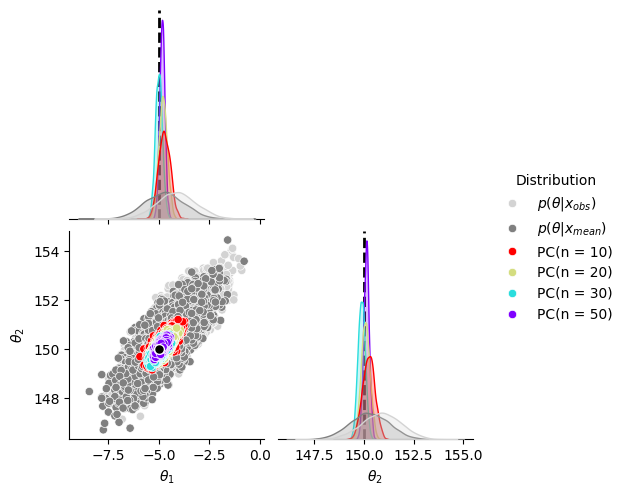

In [12]:
from matplotlib import colormaps as cm
samples_true_mean = task.true_posterior(torch.mean(x_obs_100[:100], axis=0)).sample((N_SAMPLES,)).numpy()
pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_n.values()),
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC(n = {k})" for k in samples_per_n],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_n)).cpu()],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    # plot_bounds=([-10, 2], [140, 170]),
)

#### Analyzing the Langevin corrector
PC sampling with `predictor_type='id'` is Langevin Dynamics without predictior. When `predictor_type='ddim'`, the sde solver is used. The goal is to be able to use it without any langevin correction (`n_steps=0`).

1. We verify if we can recover the original F-NPSE results with our code (`predictor_type='id', 'correction_lda=0'`).
2. We check how many langevin steps are needed to get good results with the `ddim` predictor (for `correction_lda=0.1`).

**ATTENTION**: `n_steps=0` gives very sharp possibly biased posterior approximations (see below). 

In [13]:
samples_per_predictor = {}
for predictor, n_steps, correction_lda in zip(['id', 'ddim', 'ddim', 'ddim', 'ddim','ddim'], [5, 5, 2, 1, 0, 0], [0, 0.01, 0.01, 0.01, 0.01, 0]): 
    samples_langevin_ = score_net.predictor_corrector((N_SAMPLES,),
                                                      x=x_obs_100_[:10].cuda(),
                                                      steps=1000,
                                                      prior_score_fun=diffused_prior_score,
                                                      eta=1,
                                                      corrector_lda=0.1,
                                                      n_steps=n_steps,
                                                      r=.5,
                                                      predictor_type=predictor,
                                                      verbose=True).cpu()
    samples_per_predictor[predictor+f", n-steps={n_steps}"] = samples_langevin_ * theta_train.std(axis=0) + theta_train.mean(axis=0)

  0%|          | 1/1000 [00:00<04:27,  3.73it/s]

100%|██████████| 1000/1000 [00:45<00:00, 22.10it/s]


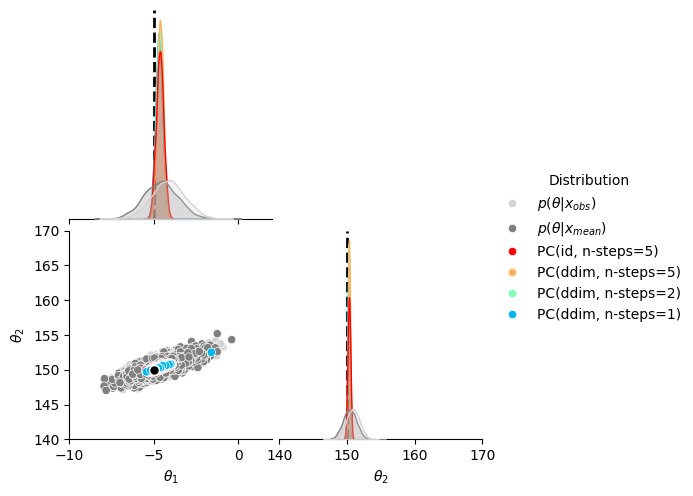

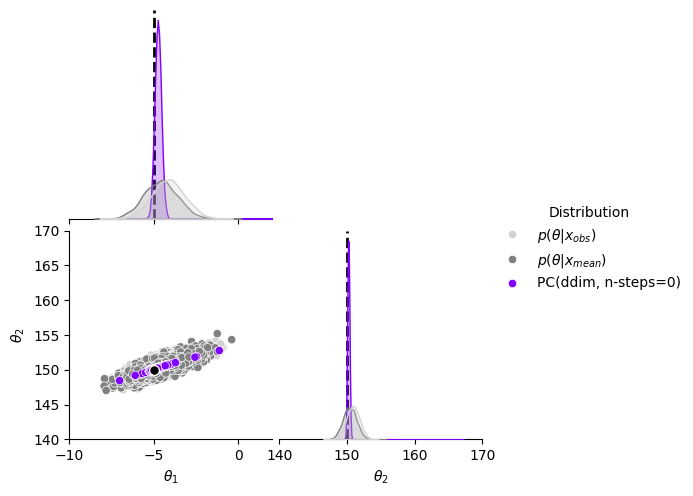

In [14]:
from matplotlib import colormaps as cm
samples_true_mean = task.true_posterior(torch.mean(x_obs_100[:10], axis=0)).sample((N_SAMPLES,)).numpy()

pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_predictor.values())[:4],
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC({k})" for k in samples_per_predictor][:4],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_predictor)).cpu()][:4],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [140, 170]),
)

pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_predictor.values())[4:5],
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC({k})" for k in samples_per_predictor][4:5],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_predictor)).cpu()][4:5],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [140, 170]),
)